In [1]:
import os
import pandas as pd
import numpy as np
import mplfinance as mpf

from binance.client import Client
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
API_KEY = os.environ.get('BINANCE_API_KEY')
API_SECRET = os.environ.get('BINANCE_API_SECRET')

client = Client(API_KEY, API_SECRET)®

In [2]:
# tickers = client.get_all_tickers()
# ticker_dataframe = pd.DataFrame(tickers)
# ticker_dataframe.head()

In [3]:
# Getting depth data
# depth = client.get_order_book(symbol='ETHUSDT')
# depth_dataframe = pd.DataFrame(depth['asks'])
# depth_dataframe.columns = ['Price', 'Volume']
# depth_dataframe.head()

In [35]:
# Getting historical data
historical_data = client.get_historical_klines('ETHUSDT', Client.KLINE_INTERVAL_1HOUR, '7 May 2022', '20 Ma 2022')
hist_df = pd.DataFrame(historical_data)
hist_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
hist_df['Close Time'] = pd.to_datetime(hist_df['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
hist_df[numeric_columns] = hist_df[numeric_columns].apply(pd.to_numeric, axis=1)     
# hist_df.set_index('Open Time', inplace=True)
# hist_df.info()
hist_df.head()
# hist_df['Volatility'].head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2022-05-07 00:00:00,2692.86,2698.27,2683.43,2686.87,9650.1774,2022-05-07 00:59:59.999000064,2.595917e+07,14924,4985.6441,1.341095e+07,0
1,2022-05-07 01:00:00,2686.86,2695.00,2677.43,2687.85,7636.1043,2022-05-07 01:59:59.999000064,2.051217e+07,12713,3781.5288,1.015745e+07,0
2,2022-05-07 02:00:00,2687.85,2688.58,2679.78,2682.14,7060.5978,2022-05-07 02:59:59.999000064,1.894861e+07,12397,3880.1604,1.041218e+07,0
3,2022-05-07 03:00:00,2682.15,2684.32,2665.05,2669.42,10022.6008,2022-05-07 03:59:59.999000064,2.679575e+07,16120,4539.2345,1.213548e+07,0
4,2022-05-07 04:00:00,2669.43,2673.50,2655.31,2656.66,16858.1285,2022-05-07 04:59:59.999000064,4.489616e+07,21738,7439.3754,1.981282e+07,0


In [36]:
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import EMAIndicator

# Calculate MA
hist_df['MA 33'] = hist_df['Close'].rolling(33).mean()
hist_df['MA 55'] = hist_df['Close'].rolling(55).mean()
previous_33 = hist_df['MA 33'].shift(1)
previous_55 = hist_df['MA 55'].shift(1)
crossing_down = ((hist_df['MA 33'] <= hist_df['MA 55']) & (previous_33 >= previous_55))
crossing_up = ((hist_df['MA 33'] >= hist_df['MA 55']) & (previous_33 <= previous_55))
crossing_down_dates = hist_df.loc[crossing_down, 'Close Time']
crossing_up_dates = hist_df.loc[crossing_up, 'Close Time']

# Crossover Signals
hist_df['Short Signals'] = crossing_down_dates
hist_df['Long Signals'] = crossing_up_dates
hist_df['Long Signals'] = hist_df['Long Signals'].astype('int').where(hist_df['Long Signals'].notnull(),np.nan)
hist_df['Short Signals'] = hist_df['Short Signals'].astype('int').where(hist_df['Short Signals'].notnull(),np.nan)

# MACD 
exp12 = hist_df['Close'].ewm(span=12, adjust=False).mean()
exp26 = hist_df['Close'].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26
signal  = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

#Calculate EMA
indicator_ema_1 = EMAIndicator(close=hist_df['Close'], window=8)
indicator_ema_2 = EMAIndicator(close=hist_df['Close'], window=21)
hist_df['EMA 8'] = indicator_ema_1.ema_indicator()
hist_df['EMA 21'] = indicator_ema_2.ema_indicator()

# previous_33 = hist_df['EMA 8'].shift(1)
# previous_55 = hist_df['EMA 20'].shift(1)

# crossing_down = ((hist_df['EMA 8'] <= hist_df['EMA 20']) & (previous_33 >= previous_55))
# crossing_up = ((hist_df['EMA 8'] >= hist_df['EMA 20']) & (previous_33 <= previous_55))
# crossing_down_dates = hist_df.loc[crossing_down, 'Close Time']
# crossing_up_dates = hist_df.loc[crossing_up, 'Close Time']

# # Crossover Signals
# hist_df['Short Signals'] = crossing_down_dates
# hist_df['Long Signals'] = crossing_up_dates
# hist_df['Long Signals'] = hist_df['Long Signals'].astype('int').where(hist_df['Long Signals'].notnull(),np.nan)
# hist_df['Short Signals'] = hist_df['Short Signals'].astype('int').where(hist_df['Short Signals'].notnull(),np.nan)


# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=hist_df["Close"], window=20, window_dev=2)

# Add Bollinger Bands features
hist_df['PercentB'] = indicator_bb.bollinger_pband()
hist_df['UpperB'] = indicator_bb.bollinger_hband()
hist_df['LowerB'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
hist_df['BB High'] = indicator_bb.bollinger_hband_indicator()
# Add Bollinger Band low indicator
hist_df['BB Low'] = indicator_bb.bollinger_lband_indicator()


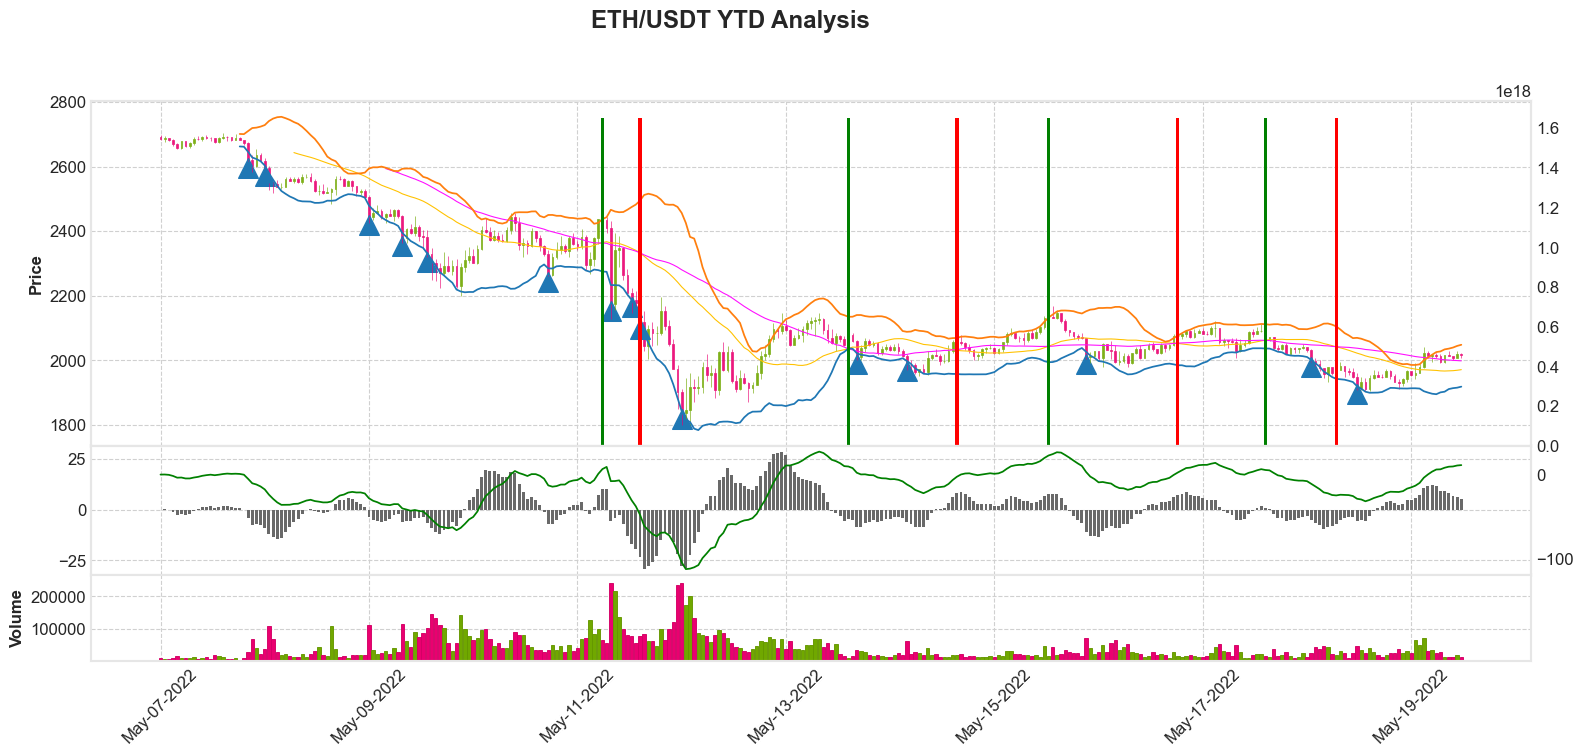

In [37]:
def percentB_belowzero(percentB,price):
    import numpy as np
    signal   = []
    previous = -1.0
    for date,value in percentB.iteritems():
        if value < 0 and previous >= 0:
            signal.append(price[date]*0.99)
        else:
            signal.append(np.nan)
        previous = value
    return signal

bb_low = percentB_belowzero(hist_df['PercentB'], hist_df['Close'])
# apd = mpf.make_addplot(bb_signal,type='scatter')
# Plot
signals = [
        mpf.make_addplot(bb_low, type='scatter', markersize=200, marker='^'),
        # mpf.make_addplot(hist_df['BB Low'], type='scatter', markersize=200, marker='^'),
        mpf.make_addplot(hist_df['Long Signals'], type='bar', color='g', y_on_right=False),
        mpf.make_addplot(hist_df['Short Signals'], type='bar', color='r', y_on_right=False),
        # mpf.make_addplot(exp12,color='lime'),
        # mpf.make_addplot(exp26,color='c'),
        # mpf.make_addplot(signal, panel=1, color='red', secondary_y=True),
        mpf.make_addplot(histogram, type='bar', width=0.7, panel=1,
                         color='dimgray', alpha=1, secondary_y=False),
        mpf.make_addplot(macd, panel=1, color='green', secondary_y=True),
        mpf.make_addplot(hist_df['LowerB']),
        mpf.make_addplot(hist_df['UpperB']),
        # mpf.make_addplot(hist_df['EMA 8']),
        # mpf.make_addplot(hist_df['EMA 21'])        
]
# style  = mpf.make_mpf_style(base_mpl_style='yahoo')
# mpf.plot(tdf,addplot=apd)
mpf.plot(hist_df.set_index('Close Time'),
        type='candle', 
        style='binance', 
        volume=True,
        title='ETH/USDT YTD Analysis',
        figsize=[20,8], 
        # figscale=1.2,
        mav=(33,55),
        # tight_layout=True,
        datetime_format='%b-%d-%Y',
        volume_panel=2,
        panel_ratios=(8,3,2),
        addplot=signals
        )

In [38]:
df_signals = hist_df.loc[(hist_df['Long Signals'] > 0) | (hist_df['Short Signals'] > 0)]
# df_signals.style.format({'Close Time': lambda t: t.strftime("%m/%d/%Y")})
# pd.to_datetime(hist_df['Open Time']/1000, unit='s')
pd.options.mode.chained_assignment = None
import math
df_signals['Signals'] = ['Long' if not math.isnan(s) else 'Short' for s in df_signals['Long Signals']]
# df_signals['Signals'] = ['Short' if s != np.nan else '' for s in df_signals['Short Signals']]

df_signals["Time"] = pd.to_datetime(df_signals["Close Time"]).dt.strftime('%b %d %Y')
result = df_signals[['Time','Close','Number of Trades', 'Signals']]
# result.reset_index(drop=True)
# df_signals
result.reset_index(drop=True)

,Time,Close,Number of Trades,Signals
0,May 11 2022,2433.00,102079,Long
1,May 11 2022,2117.42,125490,Short
2,May 13 2022,2077.00,24150,Long
3,May 14 2022,2056.48,26611,Short
4,May 15 2022,2135.39,24637,Long
5,May 17 2022,2076.48,26377,Short
6,May 18 2022,2067.19,23859,Long
7,May 18 2022,1970.32,27429,Short
